In [66]:
import jax.numpy as jnp
import jax
import flax.linen as nn
import orbax.checkpoint as ocp
from jax import make_jaxpr

In [52]:
def conv3x3(in_channels, out_channels, stride = 1, padding = 1, bias = True):
    return nn.Conv(features= out_channels,
                   kernel_size= (3, 3), 
                   strides= (stride, stride),
                   padding= padding,
                   use_bias= bias,
                   kernel_init= nn.initializers.xavier_normal(),
                   bias_init= nn.initializers.constant(0))

In [53]:
def testit(model, input, key, make = False):
    if not isinstance(input, tuple): # handles objects with different no. of inputs - UpConv and DownConv
        x = (input,)
    else:
        x = input
    key, split_key = jax.random.split(key)
    variables = model.init(split_key, *x)
    results = model.apply(variables, *x)
    print(f"\nVariable Shapes : \n{jax.tree.map(lambda x: x.shape, variables)} \n\nResults Shapes: {jax.tree.map(lambda x : x.shape, results)}")
    if make:
        print(f"\n\n\nResults : {results}")
        return make_jaxpr(lambda variables, *x: model.apply(variables, *x))(variables, *x)
    return

In [54]:
key = jax.random.key(0)

        key, split_key = jax.random.split(key)
        testit(conv3x3(3, 3,), jnp.ones((1, 3, 3, 1)), key)

In [55]:
key, split_key = jax.random.split(key)
testit(conv3x3(3, 3,), jnp.ones((1, 3, 3, 1)), key)


Variable Shapes : 
{'params': {'bias': (3,), 'kernel': (3, 3, 1, 3)}} 

Results Shapes: (1, 3, 3, 3)


In [56]:
def conv1x1(in_channels, out_channels):
    return nn.Conv(features= out_channels, 
                   kernel_size= 1,
                   strides= 1,
                   kernel_init= nn.initializers.xavier_normal(),
                   bias_init= nn.initializers.constant(0))

In [57]:
shape = (1, 32, 32, 1)
_, h, w = shape[:-1]
h, w

(32, 32)

In [58]:
class Upsample(nn.Module):
    method : str = 'bilinear'
    scale : int = 2

    @nn.compact
    def __call__(self, x):
        shape = x.shape
        shape = (shape[0], shape[1]*self.scale, shape[2]*self.scale, shape[3])
        return jax.image.resize(image = x, shape = shape, method = self.method)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    '''
    Upsample not implemented, need to find alternative
    '''
    if mode == 'transpose':
        return nn.ConvTranspose(features= out_channels,
                            kernel_size= (2, 2),
                            strides= (2, 2))
    else:
        return nn.Sequential([Upsample(method = 'bilinear', scale = 2),
                              conv1x1(in_channels, out_channels)])
                   

In [59]:
key, split_key = jax.random.split(key)
testit(upconv2x2(3, 3, mode = 'transpose'), jnp.ones((1, 3, 3, 1)), key)


Variable Shapes : 
{'params': {'bias': (3,), 'kernel': (2, 2, 1, 3)}} 

Results Shapes: (1, 6, 6, 3)


In [60]:
key, split_key = jax.random.split(key)
testit(upconv2x2(3, 3, mode = 'bilinear'), jnp.ones((1, 3, 3, 1)), key)


Variable Shapes : 
{'params': {'layers_1': {'bias': (3,), 'kernel': (1, 1, 3)}}} 

Results Shapes: (1, 6, 6, 3)


        key, split_key = jax.random.split(key)
        testit(conv1x1(3, 3,), jnp.ones((1, 3)), key)

In [61]:
class DownConv(nn.Module):
    in_channels : int
    out_channels : int
    pooling : bool

    def setup(self):
        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)
        self.conv3 = conv3x3(self.out_channels, self.out_channels)

    def __call__(self, x):
        
        xskip = self.conv1(x)
        x = nn.relu(self.conv2(xskip))
        x = nn.relu(self.conv3(x) + xskip)
        before_pool = x

        if self.pooling:
            x = nn.max_pool(x,
                            window_shape= (2, 2),
                            strides= (2, 2))
            
        return x, before_pool


        key, split_key = jax.random.split(key)
        testit(DownConv(3, 3, True), jnp.ones((1, 3, 3, 3)), key = key, make = False)

In [62]:
class UpConv(nn.Module):
    in_channels : int
    out_channels : int
    merge_mode : str = 'concat'
    up_mode : str = 'transpose'

    def setup(self):
        self.upconv = upconv2x2(self.in_channels, self.out_channels,mode=self.up_mode)
        self.conv1 = conv3x3(self.out_channels, self.out_channels) ## refine for flax
        self.conv2 = conv3x3(self.out_channels, self.out_channels)
        self.conv3 = conv3x3(self.out_channels, self.out_channels)

    def __call__(self, from_down, from_up):
        
        from_up = self.upconv(from_up) 
        if self.merge_mode == 'concat':
            x = jnp.concatenate([from_up, from_down], axis = -1) # check axis channel is last for jax
        else:
            x = from_up + from_down

        xskip = self.conv1(x) 
        x = nn.relu(self.conv2(xskip))
        x = nn.relu(self.conv3(x) + xskip)

        return x


In [63]:
key, split_key = jax.random.split(key)
a = jnp.ones((1, 4, 4, 64))
b = jnp.ones((1, 2, 2, 64))
x = (a, b)
testit(UpConv(3, 128), input = x, key = key, make = False)


Variable Shapes : 
{'params': {'conv1': {'bias': (128,), 'kernel': (3, 3, 192, 128)}, 'conv2': {'bias': (128,), 'kernel': (3, 3, 128, 128)}, 'conv3': {'bias': (128,), 'kernel': (3, 3, 128, 128)}, 'upconv': {'bias': (128,), 'kernel': (2, 2, 64, 128)}}} 

Results Shapes: (1, 4, 4, 128)


        key, split_key = jax.random.split(key)
        a = jnp.ones((1, 4, 4, 64))
        b = jnp.ones((1, 2, 2, 64))
        x = (a, b)
        testit(UpConv(3, 128), input = x, key = key, make = False)

In [64]:
import torch
print(torch.sin(torch.tensor([5])))
print(jnp.sin(5))

tensor([-0.9589])
-0.9589243


## Add Xavier Init to the model by passing the arguments for each module in the [UN](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial4/Optimization_and_Initialization.html#:~:text=kernel_init%20%3A%20Callable%20%3D%20nn.linear.default_kernel_init)

#### [LR Scheduler](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html#:~:text=of%20the%20training-,lr_schedule,-%3D%20optax.) 

#### ReduceONPlateaur available in optax

#### [Clip Gradients](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.html#:~:text=optimizer%20%3D%20optax.chain(%0A%20%20%20%20%20%20%20%20%20%20%20%20optax.clip_by_global_norm(1.0)%2C%20%20%23%20Clip%20gradients%20at%20norm%201%0A%20%20%20%20%20%20%20%20%20%20%20%20optax.adam(lr_schedule)%0A%20%20%20%20%20%20%20%20))

In [65]:
class UN(nn.Module):
    levels : int
    channels : int = 3
    depth : int = 5
    start_filts : int = 64
    up_mode : str = 'transpose'
    merge_mode : str = 'add'

    def setup(self):
        if self.up_mode not in ('transpose', 'upsample'):
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(self.up_mode))
        
        if self.merge_mode not in ('concat', 'add'):
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(self.up_mode))

        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError("up_mode \"upsample\" is incompatible "
                             "with merge_mode \"add\" at the moment "
                             "because it doesn't make sense to use "
                             "nearest neighbour to reduce "
                             "depth channels (by half).")
        
        down_convs = []
        up_convs = []

        for i in range(self.depth):
            ins = self.channels * self.levels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < self.depth-1 else False

            module = DownConv(ins, outs, pooling=pooling)
            down_convs.append(module)
        self.down_convs = down_convs

        for i in range(self.depth-1):
            ins = outs
            outs = ins // 2
            module = UpConv(ins, outs, up_mode=self.up_mode,merge_mode=self.merge_mode)
            up_convs.append(module)
        self.up_convs = up_convs

        self.conv_final = conv1x1(outs, self.channels)



    def __call__(self, x):
        
        stack = None
        factor = 10.0
        for i in range (self.levels):
            scale = x.copy()*(factor**(-i))
            scale = jnp.sin(scale)
            if stack is None:
                stack = scale
            else:
                stack = jnp.concatenate([stack,scale],axis = -1)
        
        x = stack
        
        encoder_outs = []
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)
        
        x = self.conv_final(x)

        return x
    
    def photonLoss(self, result, target):
        expEnergy = jnp.exp(result)
        perImage = -jnp.mean(result*target, axis = (-1, -2, -3), keepdims=True)
        perImage += jnp.log(jnp.mean(expEnergy, axis = (-1, -2, -3), keepdims= True))*jnp.mean(target, axis = (-1, -2, -3), keepdims= True)
        return jnp.mean(perImage)

        key, split_key = jax.random.split(key)
        a = jnp.ones((1, 128, 128, 3))
        # b = jnp.ones((1, 3, 3, 64))
        x = a
        testit(UN(levels= 10), input = x, key = key, make = False)

In [66]:
key, split_key = jax.random.split(key)
a = jnp.ones((1, 128, 128, 3))
# b = jnp.ones((1, 3, 3, 64))
x = a
testit(UN(levels= 10), input = x, key = key, make = False)


Variable Shapes : 
{'params': {'conv_final': {'bias': (3,), 'kernel': (1, 64, 3)}, 'down_convs_0': {'conv1': {'bias': (64,), 'kernel': (3, 3, 30, 64)}, 'conv2': {'bias': (64,), 'kernel': (3, 3, 64, 64)}, 'conv3': {'bias': (64,), 'kernel': (3, 3, 64, 64)}}, 'down_convs_1': {'conv1': {'bias': (128,), 'kernel': (3, 3, 64, 128)}, 'conv2': {'bias': (128,), 'kernel': (3, 3, 128, 128)}, 'conv3': {'bias': (128,), 'kernel': (3, 3, 128, 128)}}, 'down_convs_2': {'conv1': {'bias': (256,), 'kernel': (3, 3, 128, 256)}, 'conv2': {'bias': (256,), 'kernel': (3, 3, 256, 256)}, 'conv3': {'bias': (256,), 'kernel': (3, 3, 256, 256)}}, 'down_convs_3': {'conv1': {'bias': (512,), 'kernel': (3, 3, 256, 512)}, 'conv2': {'bias': (512,), 'kernel': (3, 3, 512, 512)}, 'conv3': {'bias': (512,), 'kernel': (3, 3, 512, 512)}}, 'down_convs_4': {'conv1': {'bias': (1024,), 'kernel': (3, 3, 512, 1024)}, 'conv2': {'bias': (1024,), 'kernel': (3, 3, 1024, 1024)}, 'conv3': {'bias': (1024,), 'kernel': (3, 3, 1024, 1024)}}, 'up

In [67]:
def photonLoss(result, target):
        expEnergy = jnp.exp(result)
        perImage = -jnp.mean(result*target, axis = (-1, -2, -3), keepdims=True)
        perImage += jnp.log(jnp.mean(expEnergy, axis = (-1, -2, -3), keepdims= True))*jnp.mean(target, axis = (-1, -2, -3), keepdims= True)
        return jnp.mean(perImage)

In [65]:
import os
os.chdir('/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP/gap')
# from BinomDatasetv4 import BinomDataset
from torch.utils.data import DataLoader
from tifffile import imread, imsave
import numpy as np
from BinomDataset_JAX import BinomDataset

In [2]:
data = np.concatenate((imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/trainingDataGT.tif'), imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testDataGT.tif')))
minpsnr = -40
maxpsnr = -5

In [3]:
dataset = BinomDataset(data[:round(data.shape[0]*0.9)], 256, minpsnr, maxpsnr)
val_dataset = BinomDataset(data[round(data.shape[0]*0.9):], 256, minpsnr, maxpsnr)

### Dataloader forcefully changes the images to torch tensor, use collate to change it to numpy

In [4]:
def collate_fn(batch):
    return np.array(batch)

In [5]:
train_loader = DataLoader(dataset, batch_size= 1, shuffle = True, drop_last= True, pin_memory= False, num_workers= 12, collate_fn= collate_fn)
val_loader = DataLoader(val_dataset, batch_size= 1, shuffle= False, drop_last= False, pin_memory= False, num_workers= 12, collate_fn = collate_fn)

In [24]:
import matplotlib.pyplot as plt

img = next(iter(train_loader))[:,:,:,-1:]
# np.array(img).shape
# img[:,:,:,-1:].shape
img.shape

(1, 256, 256, 1)

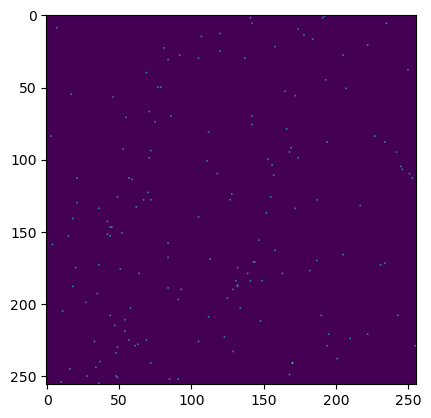

In [11]:
plt.imshow(img[0, :, :, 1])

## the PhotonLoss can be implemented directly in python + jax as the optax follows the same method

### Valid Training Loop for GAP
* [Flax Training with TrainState](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial3/Activation_Functions.html#Training-a-model)

In [2]:
import jax
jax.local_devices()[0].platform, jax.process_index(), jax.process_count()


('gpu', 0, 1)

In [47]:
img.reshape((jax.local_device_count(), -1) + img.shape[1:])

array([ True])

In [1]:
from flax.training import train_state, checkpoints
import optax
from optax.contrib import reduce_on_plateau
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter


In [3]:
jax.local_devices()[0].platform

'gpu'

### Test Trainer on GPU and make necessary updates for TPU and test on Kaggle


#### The following strategy is from huggingface is [nice](https://github.com/huggingface/transformers/blob/main/examples/flax/vision/run_image_classification.py#L469), they use pmap!!

In [63]:
from flax.training.early_stopping import EarlyStopping

In [78]:
class GAPXTrainer:
    ''' 
    Credits for Trainer Module : https://github.com/phlippe/jax_trainer
    '''
    def __init__(self, root_dir, gradient_clip_val, epochs, dataloader, model: nn.Module, lr = 1e-4, seed = 42, channels = 1):
        super().__init__()
        self.root_dir = root_dir
        self.gradient_clip_val = gradient_clip_val
        self.max_epochs = epochs
        self.img = next(iter(dataloader))[:,:,:,channels:]
        self.learning_rate= lr
        self.seed = seed
        self.channels = channels
        self.platform = jax.local_devices()[0].platform
        self.model = model
        self.logger = SummaryWriter(log_dir= self.root_dir)
        self.earlystop = EarlyStopping(min_delta= 1e-3, patience= 10)
        self.init_training()
        self.init_model()
        if self.platform == 'gpu': 
            print(f'GPU detected with {jax.process_count()} Device(s).')
        elif self.platform == 'tpu':
            print(f'TPU detected with {jax.process_count()} Device(s).')
        else: 
            print(f'CPU detected, Training will be slow!.')


    def init_model(self):
        ''' 
        Initializes the Unet model for GAP training
        '''
        init_rng = jax.random.key(self.seed)
        params = self.model.init(init_rng, self.img)
        self.state = train_state.TrainState(step=0,
                                            apply_fn=self.model.apply,
                                            params=params,
                                            tx=None,
                                            opt_state=None)
    
    def init_optimizer(self):
        ''' 
        Initializes adam optimizer with gradient clipping and learning rate schedule to reduce on plateau
        '''
        tx = optax.chain(optax.clip(self.gradient_clip_val),
                         optax.adam(learning_rate= self.learning_rate),
                         optax.contrib.reduce_on_plateau(factor = 0.5))
        
        self.state = train_state.TrainState.create(apply_fn= self.model.apply_fn,
                                                   params= self.state.params,
                                                   tx= tx)
    
    def photonLoss(self, result, target):
        ''' 
        GAP PhotonLoss
        '''
        expEnergy = jnp.exp(result)
        perImage = -jnp.mean(result*target, axis = (-1, -2, -3), keepdims=True)
        perImage += jnp.log(jnp.mean(expEnergy, axis = (-1, -2, -3), keepdims= True))*jnp.mean(target, axis = (-1, -2, -3), keepdims= True)

        return jnp.mean(perImage)
    
    def init_training(self):
        def train_step(state, batch):
            '''
            Computes loss and applies a gradietn step
            '''
            def compute_loss(params):
                ''' 
                Computes Photon Loss
                '''
                result = state.apply_fn(params, batch[:,:,:,self.channels:])
                loss = self.photonLoss(result, batch[:,:,:,:self.channels])
                return loss

            grad_fn = jax.value_and_grad(compute_loss)
            loss, grads = grad_fn(state.params)

            state = state.apply_gradients(grads = grads)
            return state, loss
        
        def eval_step(state, batch):
            ''' 
            Computes Loss
            '''
            result = state.apply_fn(state.params, batch[:,:,:,self.channels:])
            loss = self.photonLoss(result, batch[:,:,:,:self.channels])
            return loss
        
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)
    
    def train_epoch(self, train_loader, epoch):
        ''' 
        Trains the model for the given training dataloader
        '''
        avg_loss = 0
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, loss = self.train_step(self.state, batch)
            avg_loss += loss
        avg_loss /= len(train_loader)
        self.logger.add_scalar('Loss/train ', avg_loss.item(), global_step=epoch)

    def eval_model(self, data_loader):
        ''' 
        Evaluates the model for the given validation dataloader
        '''
        avg_ploss, count = 0, 0
        for batch in data_loader:
            ploss = self.eval_step(self.state, batch)
            avg_ploss += ploss * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_ploss = (avg_ploss / count).item()
        return eval_ploss

    def save_model(self, step=0):
        ''' 
        Save the checkpoints of the model 
        '''
        checkpoints.save_checkpoint(ckpt_dir=self.root_dir,
                                    target=self.state.params,
                                    step=step,
                                    overwrite=True)

    def load_model(self):
        ''' 
        Loads the checkpoints of the model and creates its state
        '''
        state_dict = checkpoints.restore_checkpoint(ckpt_dir=f'{self.root_dir}.ckpt',
                                                    target=self.state.params)
        self.state = train_state.TrainState.create(apply_fn=self.state.apply_fn,
                                                   params=state_dict,
                                                   tx=self.state.tx)

    def checkpoint_exists(self):
        return os.path.isfile(f'{self.root_dir}.ckpt')

    def train_model(self, train_loader, val_loader):
        self.init_optimizer()
        best_eval = 1e6
        for epoch_idx in tqdm(range(1, self.max_epochs +1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % 1 == 0:
                eval_ploss = self.eval_model(val_loader)
                self.logger.add_scalar('Loss/val', eval_ploss, global_step=epoch_idx)
                self.earlystop = self.earlystop.update(eval_ploss)
                if eval_ploss <= best_eval:
                    best_eval = eval_ploss
                    self.save_model(step=epoch_idx)
                if self.earlystop.should_stop:
                    print(f'Met early stopping criteria, breaking at epoch {epoch_idx}')
                    break
            self.logger.flush()

In [62]:
loss = 3
earlystop = earlystop.update(loss)
earlystop.should_stop

True

In [85]:
model = UN(3, 1)
params = model.init(jax.random.key(5),(jnp.ones((1, 32, 32, 1))))
train_state.TrainState(step=0,
                       apply_fn=model.apply,
                       params= params,
                       tx=None,
                       opt_state=None).apply_fn

<bound method Module.apply of UN(
    # attributes
    levels = 3
    channels = 1
    depth = 5
    start_filts = 64
    up_mode = 'transpose'
    merge_mode = 'add'
)>

In [98]:
1e6

1000000.0